### INTRO
---

This notebook consists of several parts:

- competition data checks and clean up
- interactive data inspector widgets with Ipython (**YOU NEED TO RUN THE NOTEBOOK TO SEE THE WIDGETS AND THEIR OUTPUT**)
- preparation of data and build up of neural network for prediction of asleep state
- test data prediction and preparation for submission (**STILL UNABLE TO MAKE A SUBMISSION DUE TO A NOTEBOOK EXCEPTION ERROR!!!**)

---

**WARNING: Be aware that training the neural network with a large number of series_id and EPOCH may take several hours**  

---

### Library imports and data loading
---

In [1]:
import os
import numpy as np
import pandas as pd
import random
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Functional, Model
from keras.layers import Input, Conv1D, Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import Adam, Adamax
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

# Set precision to two decimals
pd.set_option("display.precision", 2)

# Charts inline
%matplotlib inline

# Ignore warning
warnings.filterwarnings("ignore")

# List files 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


In [2]:
print('Reading files.....')
path = '/kaggle/input/child-mind-institute-detect-sleep-states/'
train_events = pd.read_csv(path + 'train_events.csv')
train_series = pd.read_parquet(path + 'train_series.parquet')
test_series = pd.read_parquet(path + 'test_series.parquet')
sample_submission = pd.read_csv(path + 'sample_submission.csv')
print('..... done!')

Reading files.....
..... done!


### Training data inspection and clean up
---

Any event records without time information is of no use, so I´ll start removing those.

Also, each night can have only two events, one onset and one wakeup, so any nights breaking the rule will be discarded too.

In [3]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


Let´s start removing any event records without time information.

In [4]:
train_events = train_events.dropna(axis=0, ignore_index=True)
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9585 entries, 0 to 9584
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  9585 non-null   object 
 1   night      9585 non-null   int64  
 2   event      9585 non-null   object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 374.5+ KB


Now let´s look for any instances of "bad nights" meaning any nights with anything different to a single onset / wakeup pair.

In [5]:
bad_nights = train_events[['series_id', 'night', 'event']].groupby(by=['series_id', 'night']).count()
bad_nights.head()

event
series_id    night       
038441c925bb 1          2
             2          2
             3          2
             4          2
             6          2

In [6]:
bad_nights[bad_nights['event']!=2]

,,event
series_id,night,
0ce74d6d2106,20,1
154fe824ed87,30,1
44a41bba1ee7,10,1
efbfc4526d58,7,1
f8a8da8bdd00,17,1


So here we have a few of such cases, with just one event.

In [7]:
 train_events[(((train_events['series_id']=='0ce74d6d2106') & (train_events['night']==20)) |
               ((train_events['series_id']=='154fe824ed87') & (train_events['night']==30)) |
               ((train_events['series_id']=='44a41bba1ee7') & (train_events['night']==10)) |                
               ((train_events['series_id']=='efbfc4526d58') & (train_events['night']==7)) |
               ((train_events['series_id']=='f8a8da8bdd00') & (train_events['night']==17)))]

,series_id,night,event,step,timestamp
310,0ce74d6d2106,20,onset,332376.0,2017-09-09T22:08:00-0400
957,154fe824ed87,30,wakeup,514980.0,2019-02-25T09:45:00-0500
2668,44a41bba1ee7,10,wakeup,165684.0,2018-03-04T08:07:00-0500
9099,efbfc4526d58,7,wakeup,114864.0,2018-12-21T07:47:00-0500
9352,f8a8da8bdd00,17,wakeup,291384.0,2017-12-10T12:57:00-0500


This data is problematic, so I'll remove these records.

In [8]:
train_events = train_events[~(((train_events['series_id']=='0ce74d6d2106') & (train_events['night']==20)) |
                              ((train_events['series_id']=='154fe824ed87') & (train_events['night']==30)) |
                              ((train_events['series_id']=='44a41bba1ee7') & (train_events['night']==10)) |                
                              ((train_events['series_id']=='efbfc4526d58') & (train_events['night']==7)) |
                              ((train_events['series_id']=='f8a8da8bdd00') & (train_events['night']==17)))].reset_index(drop=True)

train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9580 entries, 0 to 9579
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  9580 non-null   object 
 1   night      9580 non-null   int64  
 2   event      9580 non-null   object 
 3   step       9580 non-null   float64
 4   timestamp  9580 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 374.3+ KB


In [9]:
series_list = list(train_events['series_id'].unique())
print('Total number of valid series in training dataset: '+ str(len(series_list)))

Total number of valid series in training dataset: 269


In [10]:
# Update train_series dataset with final set of series
train_series = train_series[train_series['series_id'].isin(series_list)].reset_index(drop=True)
# Check for nulls
train_series.isnull().any()

series_id    False
step         False
timestamp    False
anglez       False
enmo         False
dtype: bool

### A look at the test series and submission sample
---

The test series data gives us a very important requirement: we have to try and detect events (onset, wakeup) in sequences of 150 steps (x 5 sec/step = 750 seconds = 12.5 minutes).

In [11]:
list(test_series['series_id'].unique())

['038441c925bb', '03d92c9f6f8a', '0402a003dae9']

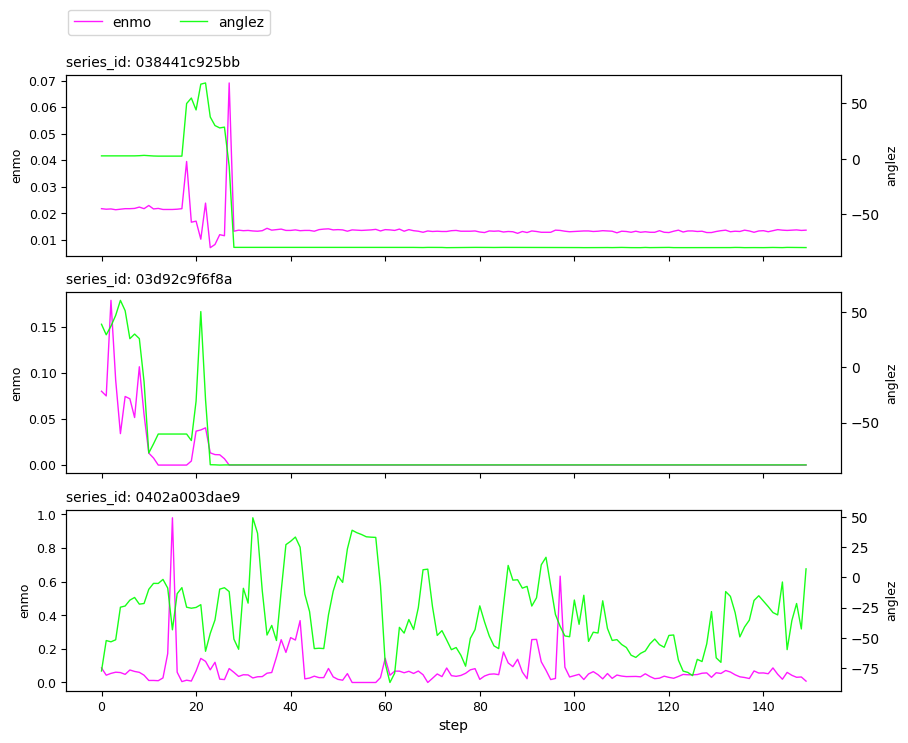

In [12]:
def plot_test_series():
    fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
    ax2 = {}
    i = 0
    test_series_list = list(test_series['series_id'].unique())
    for id in test_series_list:
        ax[i].set_title('series_id: ' + id, loc='left', fontsize=10)
        x = test_series[test_series['series_id']==id]['step']
        y_enmo = test_series[test_series['series_id']==id]['enmo']
        y_anglez = test_series[test_series['series_id']==id]['anglez']
        ax[i].plot(x, y_enmo, label='enmo', color='magenta', lw=1, alpha=0.9)
        ax[i].set_ylabel('enmo', fontsize=9)
        ax[i].tick_params(labelsize=9)
        ax2[i] = ax[i].twinx()
        ax2[i].plot(x, y_anglez, label='anglez', color='lime', lw=1, alpha=0.9)
        ax2[i].set_ylabel('anglez', fontsize=9)
        i = i + 1
    h1, l1 = ax[2].get_legend_handles_labels()
    h2, l2 = ax2[2].get_legend_handles_labels()
    plt.figlegend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(0.12, 0.97, 0.0, 0.0), ncols=2)
    ax[2].set_xlabel('step')
    plt.show()

# Plot it
plot_test_series()

In [13]:
test_series.isnull().any()

series_id    False
step         False
timestamp    False
anglez       False
enmo         False
dtype: bool

In [14]:
sample_submission

,row_id,series_id,step,event,score
0,0,038441c925bb,100,onset,0.0
1,1,038441c925bb,105,wakeup,0.0
2,2,03d92c9f6f8a,80,onset,0.5
3,3,03d92c9f6f8a,110,wakeup,0.5
4,4,0402a003dae9,90,onset,1.0
5,5,0402a003dae9,120,wakeup,1.0


### Subsampling (ONLY FOR DEVELOPMENT) and merge of train series and events datasets
---

The training_series data file is too hefty so I just sampled it down whilst developing the solution.

The actual number of series is set in the first line of the following code cell.

In [15]:
%%time
NBR_TRAINING_SERIES = 80
full_series = series_list
selected_series = random.sample(full_series, NBR_TRAINING_SERIES)

# Subsample data
train_series = train_series[train_series['series_id'].isin(selected_series)]
train_events = train_events[train_events['series_id'].isin(selected_series)]

# Merge train_series and train_events into a single fat dataframe
train_merged = pd.merge(train_series, train_events, on=['series_id', 'step', 'timestamp'], how='outer').reset_index(drop=True)

print('Nbr. of selected training series: ' + str(NBR_TRAINING_SERIES))
print('Nbr. of data points (timesteps): ' + str(len(train_merged)))
print()

Nbr. of selected training series: 80
Nbr. of data points (timesteps): 38841120

CPU times: user 1min 7s, sys: 17.5 s, total: 1min 25s
Wall time: 1min 24s


### Full series inspector widget (commented out)
---

This widget allows you to browse through the selected series of accelerometer readings. In each case, all the nights and events registered for that series are displayed.

In [ ]:
# def plot_series_and_events(series_id, train_merged):
#     # Make local copy of datasets
#     data = train_merged.copy()
#     # Filter the DataFrame based on the series_id
#     sample_series = data[data['series_id'] == series_id].copy()
#     # Convert timestamp to Pandas datetime object
#     sample_series['Date'] = sample_series['timestamp'].str.split('T', expand=True)[0]
#     sample_series['Time'] = sample_series['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
#     sample_series['timestamp'] = pd.to_datetime(sample_series['Date'] + ' ' + sample_series['Time'])
#     # Filter event data based on the series_id
#     sample_events = data[data['series_id'] == series_id].copy()
#     sample_events['Date'] = sample_events['timestamp'].str.split('T', expand=True)[0]
#     sample_events['Time'] = sample_events['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
#     sample_events['timestamp'] = pd.to_datetime(sample_events['Date'] + ' ' + sample_events['Time'])
#     # Separate events
#     sample_onset = sample_events[sample_events['event'] == 'onset'] #.dropna()
#     sample_wakeup = sample_events[sample_events['event'] == 'wakeup'] #.dropna()
#     ####################################
#     # Plot anglez and enmo along with onset and wakeup events
#     fig, ax = plt.subplots(2, 1, figsize=(16, 4), sharex=True)
#     fig.suptitle('Accelerometer readings (enmo, anglez) and annotated events for series_id = ' + series_id,
#                  fontsize=13, y=0.95)
#     ####################################    
#     for onset in sample_onset['timestamp']:
#         ax[0].axvline(x=onset, color='Navy', linestyle='--', label='onset', alpha=0.8)
#     for wakeup in sample_wakeup['timestamp']:
#         ax[0].axvline(x=wakeup, color='Red', linestyle='--', label='wakeup', alpha=0.8)    
#     ax[0].plot(sample_series['timestamp'], sample_series['enmo'], label='enmo',
#                linewidth=1, color='magenta', alpha=0.4)    
#     ax[0].set_ylabel('enmo', fontsize=11)    
#     handles, labels = ax[0].get_legend_handles_labels()
#     new_labels, new_handles = [], []
#     for handle, label in zip(handles, labels):
#         if label not in new_labels:
#             new_handles.append(handle)
#             new_labels.append(label)
#     ax[0].legend(new_handles, new_labels, loc='best', fontsize=10)            
#     ####################################    
#     for onset in sample_onset['timestamp']:
#         ax[1].axvline(x=onset, color='Navy', ls='--', label='onset', alpha=0.8)        
#     for wakeup in sample_wakeup['timestamp']:
#         ax[1].axvline(x=wakeup, color='Red', ls='--', label='wakeup', alpha=0.8)        
#     ax[1].plot(sample_series['timestamp'], sample_series['anglez'], label='anglez',
#                linewidth=1, color='lime', alpha=0.4)    
#     ax[1].set_ylabel('anglez',fontsize=11)    
#     handles, labels = ax[1].get_legend_handles_labels()
#     new_labels, new_handles = [], []
#     for handle, label in zip(handles, labels):
#         if label not in new_labels:
#             new_handles.append(handle)
#             new_labels.append(label)
#     ax[1].legend(new_handles, new_labels, loc='best', fontsize=10)        
#     ####################################    
#     plt.xlabel('timestamp')
#     plt.show()

# # Selector box handlenr function 
# def series_selector_eventhandler(change):
#     selection = series_selector.value
#     output.clear_output(wait=True)
#     with output:
#         plot_series_and_events(selection, train_merged)   

# #################################
# # Build and display widget
# series_selector = widgets.Select(description='Series_id', options=selected_series, value=selected_series[0], rows=8)
# series_selector.observe(series_selector_eventhandler, names='value')
# output = widgets.Output()
# display(series_selector, output)
# #################################

# with output:
#     plot_series_and_events(series_selector.value, train_merged)

### Single events inspector widget (commented out)
---

This widget allows you to browse through individual nights, showing enmo and anglez readings, along with the onset and wakeup events, in a window including the sleep period plus / minus six hours.

Sometimes, an error may occur if one specific series does not have a pair onset / wakeup registered for one night. Just click on another night to continue.

In [ ]:
# window = 4320 # full sleep period plus six hours before and after
# # Function to plot one pair onset - wakeup of events
# def plot_event_pair(series_id, night, train_merged, w=window):
#     # Extract onset and wakeup events on the night
#     onset_id = train_merged[(train_merged['series_id']==series_id) &
#                             (train_merged['night']==night) &
#                             (train_merged['event']=='onset')].index[0]
#     wakeup_id = train_merged[(train_merged['series_id']==series_id) &
#                              (train_merged['night']==night) &
#                              (train_merged['event']=='wakeup')].index[0]
#     sample_pair = train_merged.iloc[onset_id - w : wakeup_id + w]
    
#     # Plot charts of enmo and anglez, with onset and wakeup events for one night
#     fig, ax = plt.subplots(2,1, figsize=(20,4), sharex=True)
#     fig.suptitle('Full sleep period plus / minus six hours for series_id = ' + str(series_id) + ', night = ' + str(night),
#                  fontsize=13, y=0.95)
#     #############
#     ax[0].plot(sample_pair['step'], sample_pair['enmo'], label='enmo',
#                color='magenta', lw=1, alpha=0.6)
#     ax[0].axvline(train_merged.iloc[onset_id]['step'], label='onset', ls='--', color='Navy', alpha=0.9)
#     ax[0].axvline(train_merged.iloc[wakeup_id]['step'], label='wakeup', ls='--', color='Red', alpha=0.9)
#     ax[0].axvspan(train_merged.iloc[onset_id]['step'], train_merged.iloc[wakeup_id]['step'], ymin=0, ymax=1,
#                   color='coral', linewidth=0.1, alpha=0.1, label='asleep')
#     ax[0].legend(loc='best', fontsize=10)
#     ##########################
#     ax[1].plot(sample_pair['step'], sample_pair['anglez'], label='anglez',
#                    color='lime', lw=1, alpha=0.6)
#     ax[1].axvline(train_merged.iloc[onset_id]['step'], label='onset', ls='--', color='Navy', alpha=0.9)
#     ax[1].axvline(train_merged.iloc[wakeup_id]['step'], label='wakeup', ls='--', color='Red', alpha=0.9)
#     ax[1].axvspan(train_merged.iloc[onset_id]['step'], train_merged.iloc[wakeup_id]['step'], ymin=0, ymax=1,
#                   color='coral', linewidth=0.1, alpha=0.1, label='asleep')
#     ax[1].legend(loc='best', fontsize=10)
#     ##########################
#     plt.xlabel('step')
#     plt.show()
    
#     ##########################
#     # Plot charts of single events (150 timestep windows)
#     fig, ax = plt.subplots(1,2, figsize=(20,4), sharex=False)
#     fig.suptitle('Single onset and wakeup events and emno / anglez readings in 150 timesteps window (12.5 minutes) for series_id = ' + str(series_id) + ', night = ' + str(night), 
#                  fontsize=13, y=0.95)
#     ##########################
#     single_onset = train_merged.iloc[onset_id - 75 : onset_id + 75]
#     ax[0].plot(single_onset['step'], single_onset['enmo'], color='magenta', lw=1, alpha=0.75) 
#     ax[0].axvline(train_merged.iloc[onset_id]['step'], ls='--', color='Navy', alpha=0.9, label='onset')
#     ax[0].axvspan(train_merged.iloc[onset_id]['step'], train_merged.iloc[onset_id + 75]['step'], ymin=0, ymax=1,
#                   color='coral', linewidth=0.1, alpha=0.1, label='asleep')
#     ax[0].legend(loc='upper right', fontsize=10)
#     ax[0].set_xlabel('step')
#     ax[0].set_ylabel('enmo')
#     ax0b = ax[0].twinx()
#     ax0b.plot(single_onset['step'], single_onset['anglez'], color='lime', lw=1, alpha=0.75) 
#     ax0b.set_ylabel('anglez')
#     ax0b.legend(loc='best', fontsize=10)
#     ##########################
#     single_wakeup = train_merged.iloc[wakeup_id - 75 : wakeup_id + 75]
#     ax[1].plot(single_wakeup['step'], single_wakeup['enmo'], color='magenta', lw=1, alpha=0.75)
#     ax[1].axvline(train_merged.iloc[wakeup_id]['step'], ls='--', color='Red', alpha=0.9, label='wakeup')
#     ax[1].axvspan(train_merged.iloc[wakeup_id - 75]['step'], train_merged.iloc[wakeup_id]['step'], ymin=0, ymax=1,
#                   color='coral', linewidth=0.1, alpha=0.1, label='asleep')
#     ax[1].legend(loc='upper left', fontsize=10)
#     ax[1].set_xlabel('step')
#     ax[1].set_ylabel('enmo')
#     ax1b = ax[1].twinx()
#     ax1b.plot(single_wakeup['step'], single_wakeup['anglez'], color='lime', lw=1, alpha=0.75) 
#     ax1b.set_ylabel('anglez')
#     ax1b.legend(loc='best', fontsize=10)
#     ##########################
#     plt.show()
    
# # Selector box handlenr function 
# def series_selector_2_eventhandler(change):
#     series_id = series_selector_2.value
#     night = night_selector.value
#     output_2.clear_output(wait=True)
#     with output_2:
#         plot_event_pair(series_id, night, train_merged)   
        
# def night_selector_eventhandler(change):
#     series_id = series_selector_2.value
#     night = night_selector.value
#     output_2.clear_output(wait=True)
#     with output_2:
#         plot_event_pair(series_id, night, train_merged)  

# ####################################################
# # Build and display widget
# series_selector_2 = widgets.Select(description='Series_id', value=selected_series[0], options=selected_series, rows=8)
# series_selector_2.observe(series_selector_2_eventhandler, names='value')

# nights = 25

# night_selector = widgets.Dropdown(description='Night', value=1, options=range(1, nights+1))
# night_selector.observe(night_selector_eventhandler, names='value')

# output_2 = widgets.Output()

# display(series_selector_2, night_selector, output_2)
# ####################################################

# with output_2:
#     plot_event_pair(selected_series[0], 1, train_merged)

### Creation of target column 'asleep' and visualization against accelerometer readings (predictors) and annotated events
---

The charts show two training sequences, one for an onset event and one for a wakeup, selected randomly from the full sample.

Each sequence (or event sample) consists of 150 timesteps centered around the annotated event.

In [ ]:
onset_records = list(train_merged[train_merged['event']=='onset'].index)
onset_samples = {}

for id in onset_records:
    onset_samples[id] = train_merged.iloc[id - 75 : id + 75].copy()
    onset_samples[id]['asleep'] = 0
    onset_samples[id]['asleep'] = onset_samples[id]['event'].replace({"onset":1})
    onset_samples[id]['asleep'] = onset_samples[id]['asleep'].ffill(axis ='rows')
    onset_samples[id]['asleep'].fillna(value=0, inplace=True)
    
nbr_onset_samples = len(onset_samples.keys())
# print(onset_records)
print("Nbr. onset samples for training: " + str(nbr_onset_samples))

In [ ]:
# Pick one onset_id randomly
onset_id = random.choice(onset_records)
# Plot enmo, anglez, event and asleep
fig, ax = plt.subplots(2,1, figsize=(16, 5), sharex=True)
fig.suptitle('Single onset', fontsize=13, y=0.95)
ax[0].plot(onset_samples[onset_id].step, onset_samples[onset_id].enmo, label='enmo', color='magenta', alpha=0.9)
ax[0].set_ylabel('enmo')
#####################
ax0b = ax[0].twinx()
ax0b.plot(onset_samples[onset_id].step, onset_samples[onset_id].anglez, label='anglez', color='lime', alpha=0.9)
ax0b.set_ylabel('anglez')
#####################
ax[0].axvline(train_merged.iloc[onset_id]['step'], label='onset', ls='--', lw=2, color='Navy', alpha=0.9) 
#####################
ax[1].bar(onset_samples[onset_id].step, onset_samples[onset_id].asleep, label='asleep', alpha=0.75)
ax[1].set_ylabel('asleep = 1')
ax[1].set_xlabel('step')
#####################
fig.legend(loc='center left', fontsize=11)
plt.show()

In [ ]:
wakeup_records = list(train_merged[train_merged['event']=='wakeup'].index)
wakeup_samples = {}

for id in wakeup_records:
    wakeup_samples[id] = train_merged.iloc[id - 75 : id + 75].copy()
    wakeup_samples[id]['asleep'] = 0
    wakeup_samples[id]['asleep'] = wakeup_samples[id]['event'].replace({"wakeup":1})
    wakeup_samples[id]['asleep'] = wakeup_samples[id]['asleep'].bfill(axis ='rows')
    wakeup_samples[id]['asleep'].fillna(value=0, inplace=True)

nbr_wakeup_samples = len(wakeup_samples.keys())
# print(wakeup_samples)
print("Nbr. wakeup samples for training: " + str(nbr_wakeup_samples))

In [ ]:
# Pick one wakeup_id randomly
wakeup_id = random.choice(wakeup_records)
# Plot enmo, anglez, event and asleep
fig, ax = plt.subplots(2,1, figsize=(16, 5), sharex=True)
fig.suptitle('Single wakeup', fontsize=13, y=0.95)
ax[0].plot(wakeup_samples[wakeup_id].step, wakeup_samples[wakeup_id].enmo, label='enmo', color='magenta', alpha=0.9)
ax[0].set_ylabel('enmo')
#####################
ax0b = ax[0].twinx()
ax0b.plot(wakeup_samples[wakeup_id].step, wakeup_samples[wakeup_id].anglez, label='anglez', color='lime', alpha=0.9)
ax0b.set_ylabel('anglez')
#####################
ax[0].axvline(train_merged.iloc[wakeup_id]['step'], label='wakeup', ls='--',  lw=2, color='Red', alpha=0.9) 
#####################
ax[1].bar(wakeup_samples[wakeup_id].step, wakeup_samples[wakeup_id].asleep, label='asleep', alpha=0.75)
ax[1].set_ylabel('asleep = 1')
ax[1].set_xlabel('step')
#####################
fig.legend(loc='center left', fontsize=11)
plt.show()

In [ ]:
# build dataframes of onsets and wakeups from samples dictionaries
onset_samples_df = pd.concat(onset_samples, axis=0)
wakeup_samples_df = pd.concat(wakeup_samples, axis=0)

We have two dataframes (one for onsets and another for wakeups) with a number of sequences of 150 steps centered around the specific event annotation. These will be the sequences fitted to the neural network for training.

### Creation of derived features and preparation of data for RNN training
---

Here I will create new features with the rolling averages (1 minute window) of enmo and anglez, and with their first derivative.

Then I will extract X and y and convert them into tensor flow format.

Note that given the huge size of the training dataset and the relative independence of the the different samples (surely different), I am using the full dataset for training and evaluation (in-sample testing) instead of adding additional complexity with held-out data.

In [ ]:
df1 = onset_samples_df[['series_id', 'asleep', 'anglez', 'enmo']]
df2 = wakeup_samples_df[['series_id', 'asleep', 'anglez', 'enmo']]

df1['enmo_diff'] = onset_samples_df['enmo'].diff(1)
df1['anglez_diff'] = onset_samples_df['anglez'].diff(1)

df1['enmo_ma'] = onset_samples_df['enmo'].rolling(12).mean() # 12 steps = 1 minute
df1['anglez_ma'] = onset_samples_df['anglez'].rolling(12).mean()

df2['enmo_diff'] = wakeup_samples_df['enmo'].diff(1)
df2['anglez_diff'] = wakeup_samples_df['anglez'].diff(1)

df2['enmo_ma'] = wakeup_samples_df['enmo'].rolling(12).mean()
df2['anglez_ma'] = wakeup_samples_df['anglez'].rolling(12).mean()

df = pd.concat([df1, df2], axis=0)

df = df.fillna(method='bfill')
 
# Each sample iss a 150 steps sequence with a single onset or wakeup event
NBR_TRAIN_SAMPLES = nbr_onset_samples + nbr_wakeup_samples
print("Nbr. samples for training: " + str(NBR_TRAIN_SAMPLES))

In [ ]:
TIMESTEPS = 150
features = ['anglez', 'enmo', 'anglez_diff', 'enmo_diff',  'anglez_ma', 'enmo_ma']
NBR_FEATURES = len(features)

X = df[features].to_numpy().reshape(NBR_TRAIN_SAMPLES, TIMESTEPS, NBR_FEATURES)
y = df['asleep'].to_numpy().reshape(NBR_TRAIN_SAMPLES, TIMESTEPS)

print('X shape:' + str(X.shape))
print('y shape:' + str(y.shape))

In [ ]:
X_train = X
y_train = y

### Neural network model
---

My proposed neural network model includes a 1D convolutional layer followed by a bidirectional LSTM layer or two, along with the input and output (dense) layers.

For each test sample, the model predicts the probability of each timestep belonging to the positive class (that is, the probability of the asleep state).

Pretty simple eh??? Well, may be not so much so!

In [ ]:
#####################################################
# RNN training parameters
BATCH_SIZE = 16
EPOCHS = 50
#####################################################

# Input layer
input_layer = Input(shape=(TIMESTEPS, NBR_FEATURES)) 

# Convolutional layer
conv_layer = Conv1D(filters=32, 
                    kernel_size=8,
                    strides=1,
                    activation='relu',
                    padding='same')(input_layer)

# Bidirectional LSTM layer
lstm_layer = Bidirectional(LSTM(TIMESTEPS, return_sequences=True))(conv_layer)

# Bidirectional LSTM layer
lstm_layer_2 = Bidirectional(LSTM(TIMESTEPS, return_sequences=True))(lstm_layer)

# Output layer
output_layer = Dense(1, activation='sigmoid')(lstm_layer_2)

# Build the RNN model
RNN = Model(inputs=input_layer, outputs=output_layer)

RNN.summary()

In [ ]:
print()
print('TRAINING DATASET DIMENSIONS')
print('-'*80)
print('  NUMBER OF TRAINING SERIES : ' + str(NBR_TRAINING_SERIES))
print('  TIMESTEPS PER SAMPLE : ' + str(TIMESTEPS))
print('  NUMBER OF FEATURES : ' + str(NBR_FEATURES ))
# print('  ' + str(features))
print()
print('NEURAL NETWORK TRAINING PARAMETERS')
print('-'*80)
print('  BATCH SIZE : ' + str(BATCH_SIZE))
print('  NUMBER OF EPOCHS : ' + str(EPOCHS))
print()

In [ ]:
plot_model(RNN, "deleteme.png", show_shapes=True)

In [ ]:
%%time
# Compile model
RNN.compile(optimizer=Adamax(learning_rate=1e-3),
            loss=BinaryCrossentropy())

# Define EarlyStopping callback
callback = EarlyStopping(monitor='loss', patience=3)

# Fit the model with the data
RNN_history = RNN.fit(X_train, y_train, 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, 
                      callbacks=[callback])

In [ ]:
%%time
# Convert the training history to a dataframe
RNN_history_df = pd.DataFrame(RNN_history.history)

# Plot RNN training loss vs. epochs
RNN_history_df['loss'].plot(figsize=(8,4), title='Neural network training loss', color='brown');

In [ ]:
# Make predictions and compare to true values
X_test = X_train
y_test = y_train
predicted_values = RNN.predict(X_test)

The predicted values are the probabilities of a step belonging to the asleep state. 

In [ ]:
# Onset predictions
fig, ax = plt.subplots(1,1, figsize=(10,4))
for i in range(20):
    ax.set_title('Onset events (target) and asleep probability predictions')
    ax.plot(y_test[i], linestyle='--', color='Navy')
    ax.plot(predicted_values[i], lw=1)
    ax.set_xlabel('step')
plt.show()

In [ ]:
# Wakeup predictions
fig, ax = plt.subplots(1,1, figsize=(10,4))
for i in range(20):
    ax.set_title('Wakeup events (target) and asleep probability predictions')
    ax.plot(y_test[i + nbr_onset_samples], linestyle='--', color='Red')
    ax.plot(predicted_values[i + nbr_onset_samples], lw=1)
    ax.set_xlabel('step')
plt.show()

In [ ]:
predicted_values.shape

In [ ]:
# Convert predicted asleep probabilities to binary state
predicted_asleep_state = np.where(predicted_values > 0.5, 1, 0 )
predicted_asleep_state.T

In [ ]:
predicted_asleep_state.shape

Below is a sample of the 'asleep' state values from the sample of wakeups. Only left is to identify the step at which the wakeup event occurs.

In [ ]:
fig, ax = plt.subplots(10,1, figsize=(8,10), sharex=True)
plt.suptitle('Predicted asleep state', y=0.92)
for i in range(10):
    ax[i].plot(y_test[i + nbr_onset_samples], linestyle='--', color='Red', label='Ground truth')
    ax[i].plot(predicted_asleep_state[i + nbr_onset_samples], lw=1.5, alpha=0.75, label='Predictions')
    ax[i].set_xlabel('step')
plt.show()

In [ ]:
predictions_df = pd.DataFrame(index=df.index)
predictions_df['asleep'] = predicted_asleep_state.reshape(NBR_TRAIN_SAMPLES*TIMESTEPS,1)
predictions_df['asleep_diff'] = predictions_df['asleep'].diff(1).fillna(method='bfill')
# predictions_df.reset_index(inplace=True)
predictions_df['event'] = predictions_df['asleep_diff'].replace({1 : 'onset', -1 : 'wakeup'})

predictions_df

In [ ]:
predictions_df['event'].value_counts()

It seems to be predicting the asleep state quite well (and hence also the transitions or events - yippie!).

In [ ]:
# Save the RNN model
RNN_name = 'RNN_' + str(NBR_TRAINING_SERIES) + '_SERIES_' + str(EPOCHS)+ '_EPOCHS'
RNN.save(RNN_name)

### Make predictions for submission
---

Still stuck with the "notebook threw exception" error !!!

So zeroing in....


In [ ]:
test_series

In [ ]:
test_series_ids = list(test_series['series_id'].unique())
NBR_TEST_SERIES = len(test_series_ids)

print('Nbr. test series for submission: ' + str(NBR_TEST_SERIES))
print(test_series_ids)

In [ ]:
series = {}
for id in test_series_ids:
    series[id] = test_series[test_series['series_id']==id]
    series[id]['enmo_diff'] = series[id]['enmo'].diff(1)
    series[id]['anglez_diff'] = series[id]['anglez'].diff(1)
    series[id]['enmo_ma'] = series[id]['enmo'].rolling(12).mean()
    series[id]['anglez_ma'] = series[id]['anglez'].rolling(12).mean() 
test_series = pd.concat([series[id] for id in test_series_ids], axis=0)
test_series = test_series.fillna(method='bfill')

test_series

In [ ]:
test_series.isnull().any()

In [ ]:
# Isolate test set predictors
X_test = test_series[features].to_numpy().reshape(NBR_TEST_SERIES, TIMESTEPS, NBR_FEATURES)

# Make submission predictions
test_predictions = RNN.predict(X_test)
test_classes = np.where(test_predictions > 0.5, 1,0)

# Reshape
test_predictions = test_predictions.reshape(NBR_TEST_SERIES*TIMESTEPS, 1)
test_classes = test_classes.reshape(NBR_TEST_SERIES*TIMESTEPS, 1)

In [ ]:
# Build predictions dataframe
sub_predictions = test_series[['series_id', 'step']]
sub_predictions ['asleep'] =  test_classes
sub_predictions['asleep_diff'] = sub_predictions['asleep'].diff(1).fillna(method='bfill')
sub_predictions['event'] = sub_predictions['asleep_diff'].replace({1 : 'onset', -1 : 'wakeup'})
sub_predictions['score'] = test_predictions

sub_predictions

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,6), sharex=True)
i = 0
for id in test_series_ids:
    ax[i].set_title('series_id: ' + id, loc='left', fontsize=10)
    ax[i].plot(sub_predictions[sub_predictions['series_id']==id]['step'],
               sub_predictions[sub_predictions['series_id']==id]['asleep'], lw=1.5)
    i = i + 1
plt.xlabel('step')
plt.show()

I will just select the single event from each series_id with the best score.

In [ ]:
# Isolate detected events
sub_predictions = sub_predictions.loc[((sub_predictions["event"]=='onset') |
                                       (sub_predictions["event"]=='wakeup'))
                                     ][["series_id","step","event","score"]].copy().reset_index(drop=True).reset_index(names="row_id")
sub_predictions

In [ ]:
# Obtain best predictions (predicted events with highest score)
best_preds = {}
for id in test_series_ids: 
    best_preds[id] = sub_predictions[sub_predictions['series_id']==id]
    best_preds[id] = best_preds[id][best_preds[id]['score']==best_preds[id]['score'].max()]
#     print(best_preds[id])
#     print()

# Concat single best events (highest scores) into a submission dataframe
submission_df = pd.concat([best_preds[id] for id in test_series_ids]).drop(columns='row_id').reset_index(drop=True).reset_index(names="row_id")

# Save submission data to csv file
submission_df.to_csv('submission.csv', index=False)

submission_df

---